# QF605 Fixed Income Securities
## Project Part II
## Swap Calibration
YU Lingfeng

In [90]:
# importing labraries
import numpy as np
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.optimize import brentq, fsolve, least_squares
from scipy.stats import norm
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## <a id = "top">Table of Content</a>
### [Q1. Displaced Diffusion Model Calibration](#p1)   
Reporting Black-Scholes model $dS_{n,N}(t) =\sigma_{n,N}S_{n,N}(t)dW^{n+1, N}(t)$

Displaced Diffusion Model $dS_{n,N}(t)=\sigma_{n,N}\cdot[\beta \cdot S_{n,N}(t)+(1-\beta)\cdot S_{n,N}(0)]dW^{n,N}(t)$

- ##### [1.1 $\sigma$ and $\beta$](#p11)
- ##### [1.2 Displaced Diffusion plot](#p12)

### [Q2. SABR Calibration](#p2)
- ##### [2.1 $\alpha$, $\rho$, $\nu$, assuming $\beta$=0.9](#p21)
- ##### [2.2 SABR and Displaced Diffusion plot](#p22)

### [Q3. Swaption Pricing with SABR and Calibrated DD Model](#p3)
- ##### [3.1 Interplation on Displaced Diffusion $\sigma$ and $\beta$](#p31)
- ##### [3.2 Interplation on SABR $\alpha$, $\rho$, $\nu$, assuming $\beta$=0.9](#p32)
- ##### [3.3 payer swaption 2$y$ X 10$y$](#p33)
- ##### [3.4 receiver swaption 8$y$ X 10$y$](#p34)

## <a id = "p1"> Q1. </a> Displaced Diffusion Model Calibration $\sigma$ and $ \beta$ [back to table of contents](#top)

In [91]:
def Black76Call(F, K, sigma, pvbp, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(F, K, sigma, pvbp, T):
    d1 = (np .log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return pvbp*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

def DD_Put(F, K, sigma, pvbp, beta, T):
    F_d = F/beta
    K_d = K + ((1-beta)/beta)*F
    sigma_d = sigma*beta
    
    dd_option = Black76Put(F_d, K_d, sigma_d, pvbp, T)
    
    return dd_option

def DD(F, K, sigma, pvbp, beta, T):
    if F <= K:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Call(F_d, K_d, sigma_d, pvbp, T)
    
    else:
        F_d = F/beta
        K_d = K + ((1-beta)/beta)*F
        sigma_d = sigma*beta
        
        price = Black76Put(F_d, K_d, sigma_d, pvbp, T)
        
    return price

In [92]:
def volatility(F, K, pvbp, T, sigma, beta):
    
    #price = DD(F, K, sigma, pvbp, beta, T)
    
    if F <= K:
        price = DD_Call(F, K, sigma, pvbp, beta, T)
        vol = brentq(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0, 1)
    else:
        price = DD_Put(F, K, sigma, pvbp, beta, T)
        vol = brentq(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0, 1)
    return vol

def ddcalibration(x, F, strikes, vols, pvbp, T):
    err = 0.0
    sigma = vols[5]
    
    for i, vol in enumerate(vols):
        
        err += (vol - volatility(F, strikes[i], pvbp, T, sigma, x))**2

    return err

In [93]:
df_all =\
    pd.read_csv("###P1 All DFs.csv", 
                index_col=[0])
df_all.head()

,OIS DF,LIBOR DF
Tenor,,
0.5,0.998752,0.987654
1.0,0.997009,0.972577
1.5,0.995270,0.957378
2.0,0.993531,0.942179
2.5,0.991773,0.926330


In [94]:
fsw =\
    pd.read_csv("###P1 Forward Swap Rate.csv", 
                index_col=[0])
print(fsw.columns)
fsw.columns =\
    [1, 2, 3, 5, 10] 
print(fsw.index)
fsw.index =\
    [1, 5, 10] 
fsw

Index(['X 1y', 'X 2y', 'X 3y', 'X 5y', 'X 10y'], dtype='object')
Index(['1y', '5y', '10y'], dtype='object', name='Expiry/Tenor')


,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


In [95]:
swaption = pd.read_excel ('IR Data.xlsx', 
                          sheet_name='Swaption', 
                          skiprows = 2, 
                          header = 0, 
                          index_col=[0,1])
print(swaption.columns)
swaption.columns =\
    (list(np.arange(-200,0,50)/10000) +\
    list(np.arange(-25,50,25)/10000) +\
    list(np.arange(50,250,50)/10000))
swaption=swaption/100
swaption

Index(['-200bps', '-150bps', '-100bps', '-50bps', '-25bps', 'ATM', '+25bps',
       '+50bps', '+100bps', '+150bps', '+200bps'],
      dtype='object')


-0.0200  -0.0150  -0.0100  -0.0050  -0.0025   0.0000   0.0025  \
Expiry Tenor                                                                  
1Y     1Y     0.91570  0.62030  0.44130  0.31224  0.26182   0.2250   0.2096   
       2Y     0.83270  0.61240  0.46570  0.35807  0.31712   0.2872   0.2712   
       3Y     0.73920  0.56870  0.44770  0.35745  0.32317   0.2978   0.2829   
       5Y     0.55190  0.44640  0.36510  0.30242  0.27851   0.2607   0.2498   
       10Y    0.41180  0.35040  0.30207  0.26619  0.25351   0.2447   0.2398   
5Y     1Y     0.67800  0.49090  0.38400  0.31485  0.29060   0.2726   0.2604   
       2Y     0.57880  0.46410  0.39033  0.33653  0.31531   0.2983   0.2856   
       3Y     0.53430  0.44440  0.38180  0.33437  0.31536   0.2998   0.2876   
       5Y     0.41990  0.36524  0.32326  0.29005  0.27677   0.2660   0.2573   
       10Y    0.34417  0.30948  0.28148  0.25954  0.25136   0.2451   0.2399   
10Y    1Y     0.55160  0.44320  0.37368  0.32259  0.30210   0.2854   0.2731   
       2Y     0.51170  0.42900  0.37078  0.32622  0.30800   0.2928   0.2809   
       3Y     0.48220  0.41430  0.36400  0.32439  0.30796   0.2940   0.2827   
       5Y     0.40550  0.35891  0.32181  0.29144  0.27857   0.2674   0.2580   
       10Y    0.33601  0.30509  0.27978  0.25926  0.25086   0.2437   0.2376   

               0.0050   0.0100   0.0150   0.0200  
Expiry Tenor                                      
1Y     1Y      0.2140   0.2434  0.27488  0.30297  
       2Y      0.2684   0.2851  0.31025  0.33523  
       3Y      0.2780   0.2877  0.30725  0.32833  
       5Y      0.2456   0.2512  0.26536  0.28165  
       10Y     0.2382   0.2425  0.25204  0.26355  
5Y     1Y      0.2532   0.2494  0.25320  0.25980  
       2Y      0.2765   0.2671  0.26540  0.26760  
       3Y      0.2782   0.2667  0.26200  0.26150  
       5Y      0.2502   0.2406  0.23570  0.23400  
       10Y     0.2356   0.2291  0.22490  0.22250  
10Y    1Y      0.2645   0.2561  0.25520  0.25780  
       2Y      0.2720   0.2612  0.25720  0.25710  
       3Y      0.2738   0.2618  0.25580  0.25370  
       5Y      0.2502   0.2387  0.23170  0.22800  
       10Y     0.2324   0.2244  0.21900  0.21560

In [96]:
fsw

,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


In [97]:
Expiry=[1, 5, 10]
Tenor=[1, 2, 3, 5, 10]
Beta =\
    pd.DataFrame(index=Expiry, 
                 columns=Tenor)
Sigma =\
    pd.DataFrame(index=Expiry, 
                 columns=Tenor)
initialGuess = [0.7] # beta

for ex in Expiry:
    for T in Tenor:
        
        fsr = fsw.loc[ex,T]
        strikes =\
            fsr + np.array(swaption.columns)
        market_vol =\
            swaption.loc[(str(ex)+'Y', 
                          str(T)+'Y'),:].values
        Sigma.loc[ex,T]=market_vol[5]
        
        OIS_DF =\
            df_all\
            .loc[(df_all.index<=ex+T) &\
                 (df_all.index>ex)]\
            ['OIS DF']
        pvbp =\
            0.5 * OIS_DF.sum()
        res =\
            least_squares(lambda x: 
                          ddcalibration(x, 
                                        fsr, 
                                        strikes, 
                                        market_vol,
                                        pvbp, 
                                        ex),
                          initialGuess,
                          bounds=([0,1]))
        Beta.loc[ex,T]=f"{res.x[0]:.4e}" 

Beta.columns =\
    [str(T) +'Y' for T in Tenor]
Beta.index =\
    [str(ex) +'Y' for ex in Beta.index]    
Beta.index.name = 'Swaption DD Beta'
Beta.to_csv('###P2 DD Beta.csv')
Sigma.columns =\
    [str(T) +'Y' for T in Tenor]
Sigma.index =\
    [str(ex) +'Y' for ex in Sigma.index]
Sigma.index.name = 'Swaption ATM Sigma'
Sigma.to_csv('###P2 Sigma.csv')

##### <a id = "p11"> </a> 1.1  $\sigma$ and $\beta$ [back to table of contents](#top)

In [98]:
Beta

,1Y,2Y,3Y,5Y,10Y
Swaption DD Beta,,,,,
1Y,1.5459e-12,6.4906e-08,3.3655e-07,2.0976e-06,2.4893e-05
5Y,8.9746e-07,1.5707e-07,1.5791e-05,7.3192e-06,5.7790e-02
10Y,5.1745e-07,8.9884e-09,1.6200e-06,6.1307e-05,6.4590e-04


In [99]:
Sigma

,1Y,2Y,3Y,5Y,10Y
Swaption ATM Sigma,,,,,
1Y,0.225,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.266,0.2451
10Y,0.2854,0.2928,0.294,0.2674,0.2437


##### <a id = "p12"> </a> 1.2  Displaced Diffusion plot [back to table of contents](#top)

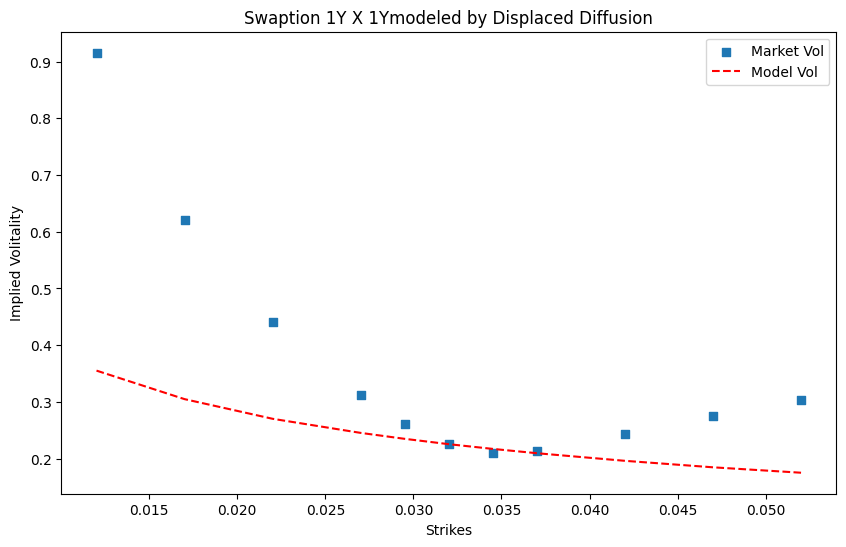

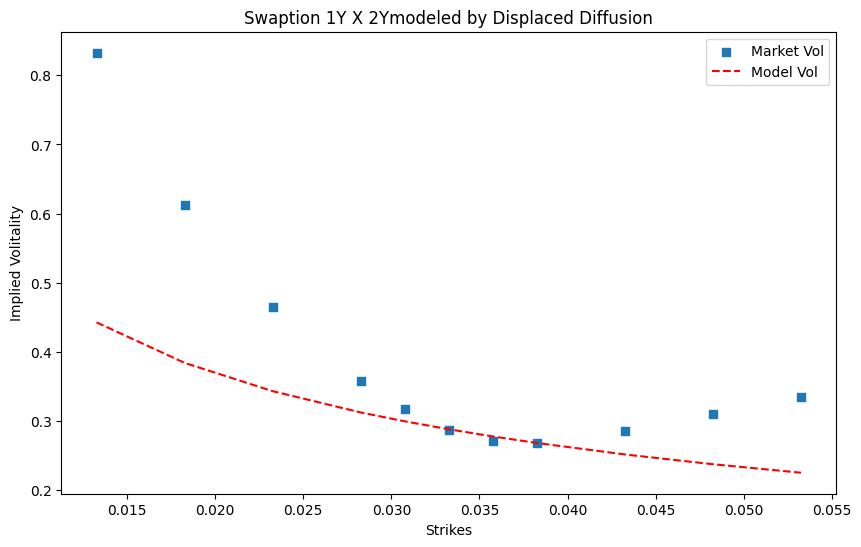

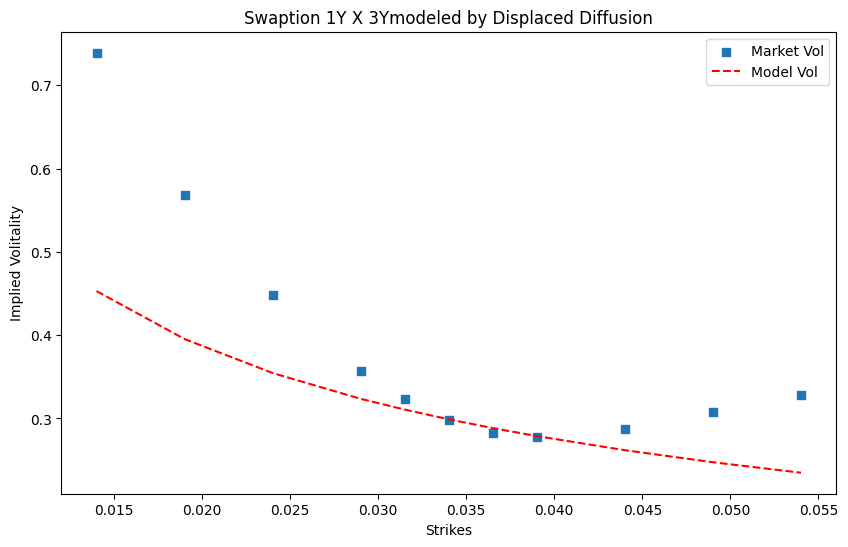

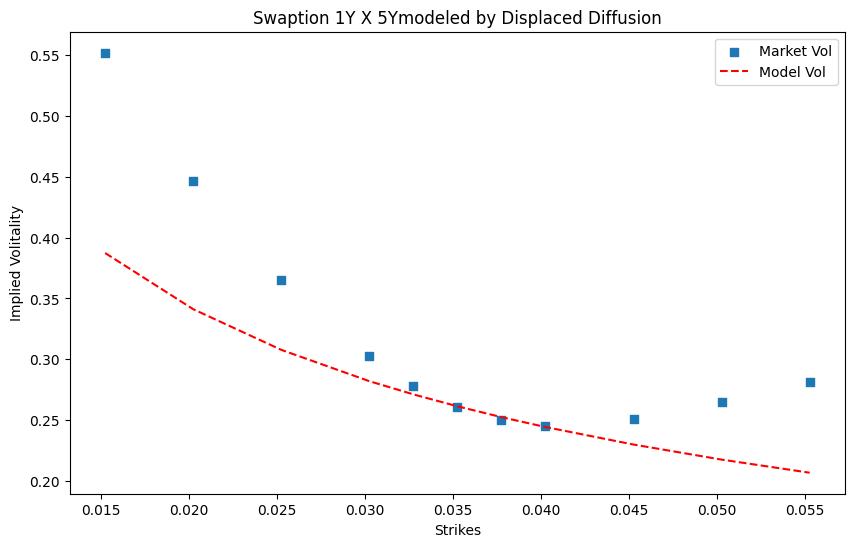

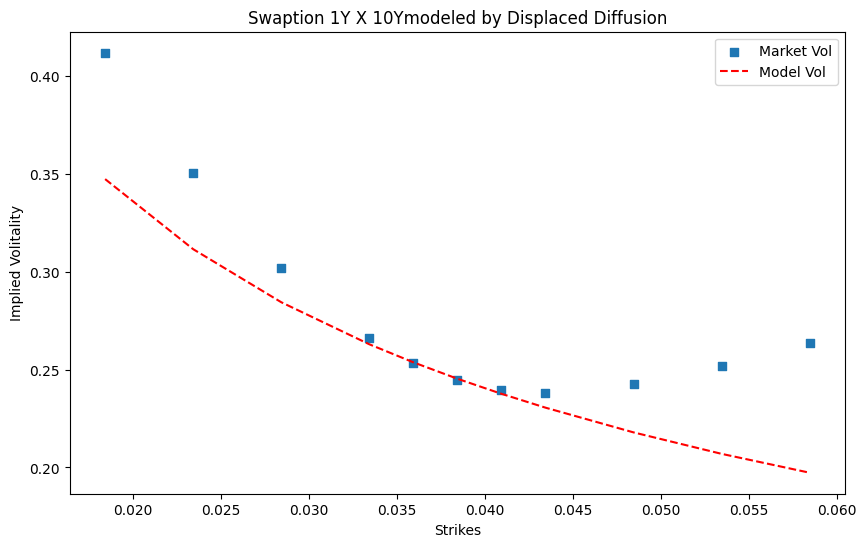

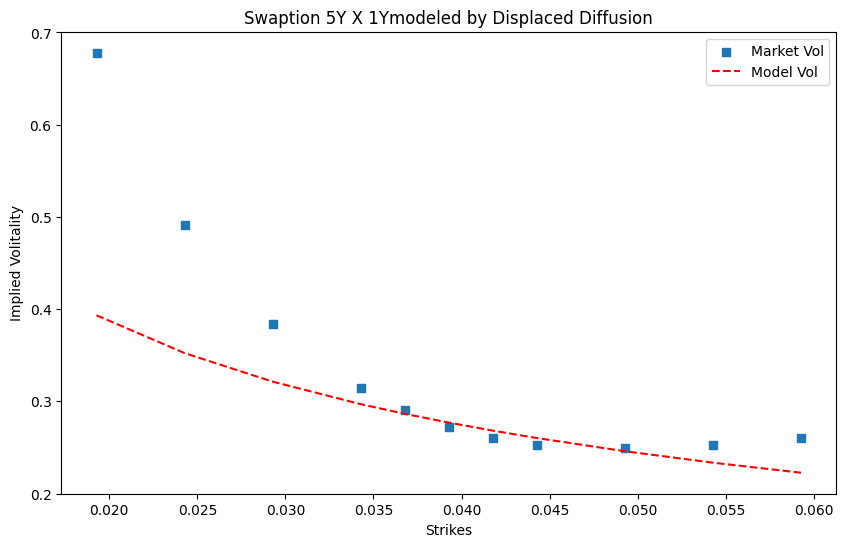

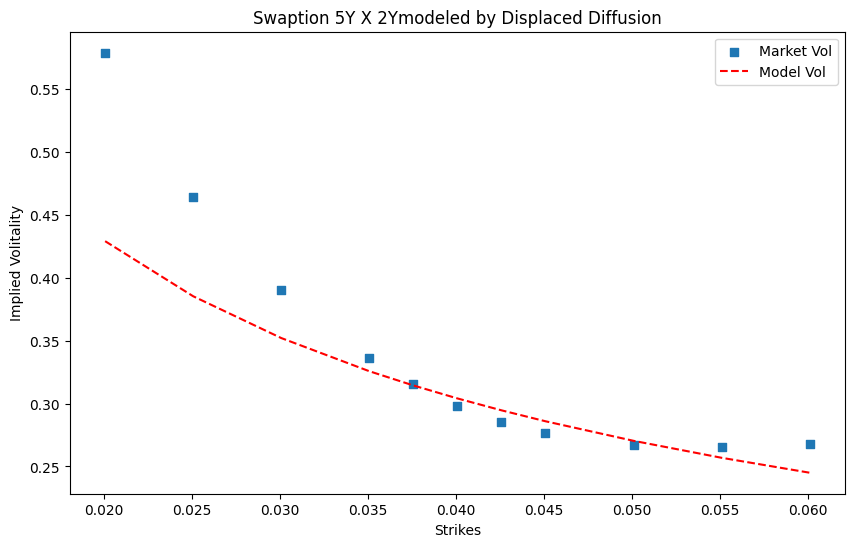

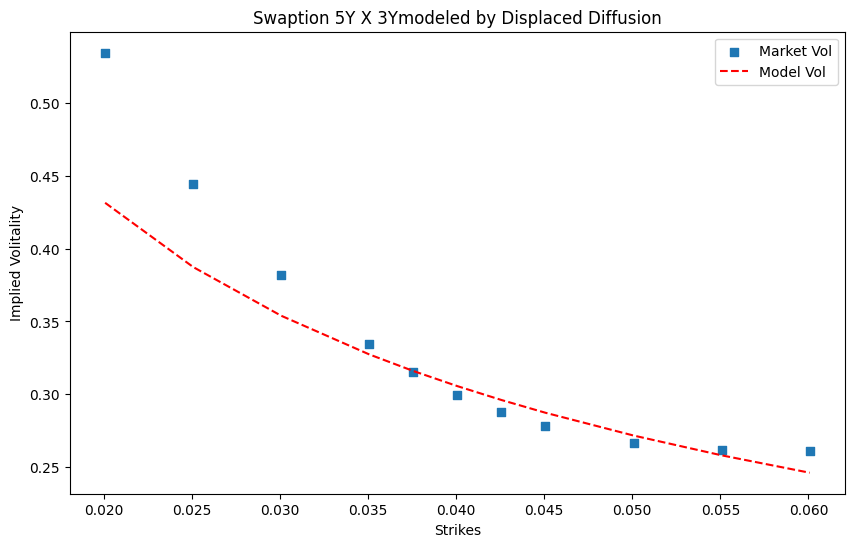

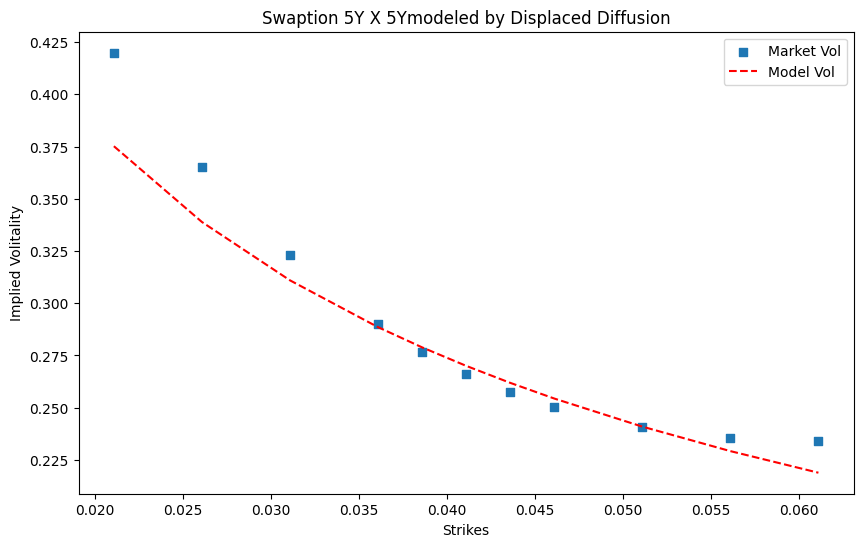

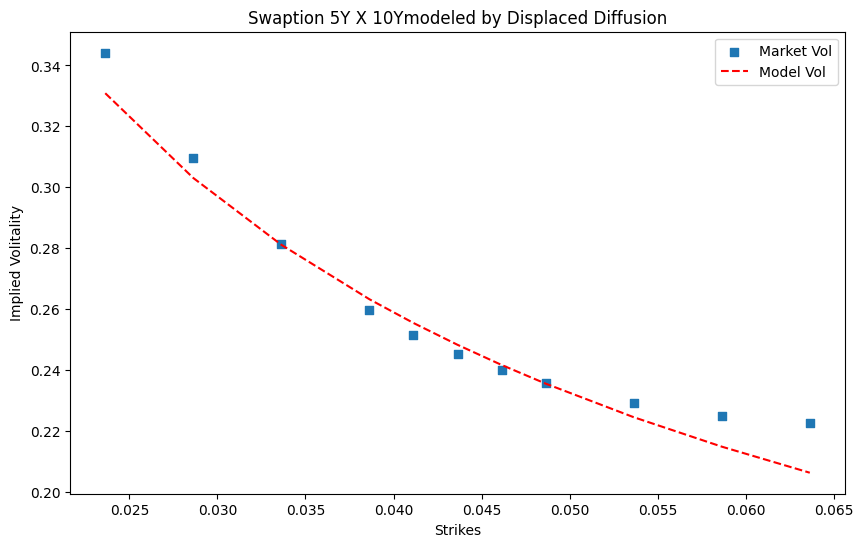

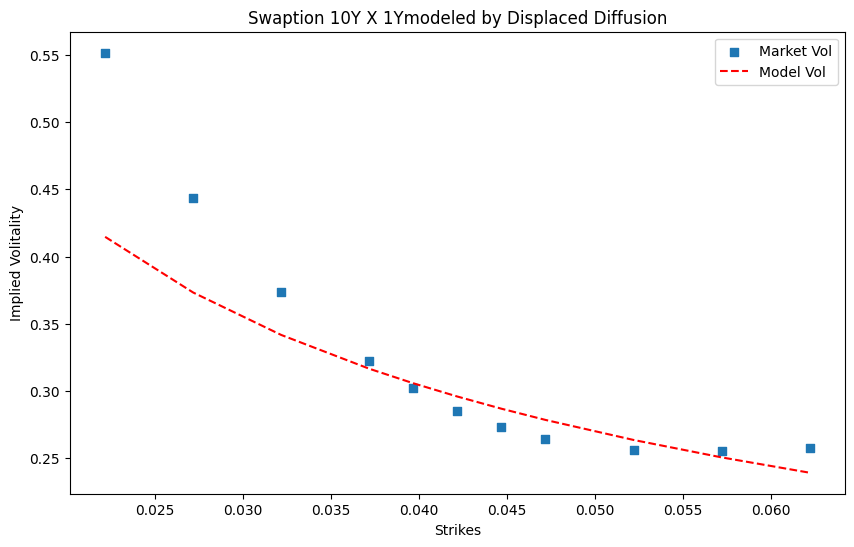

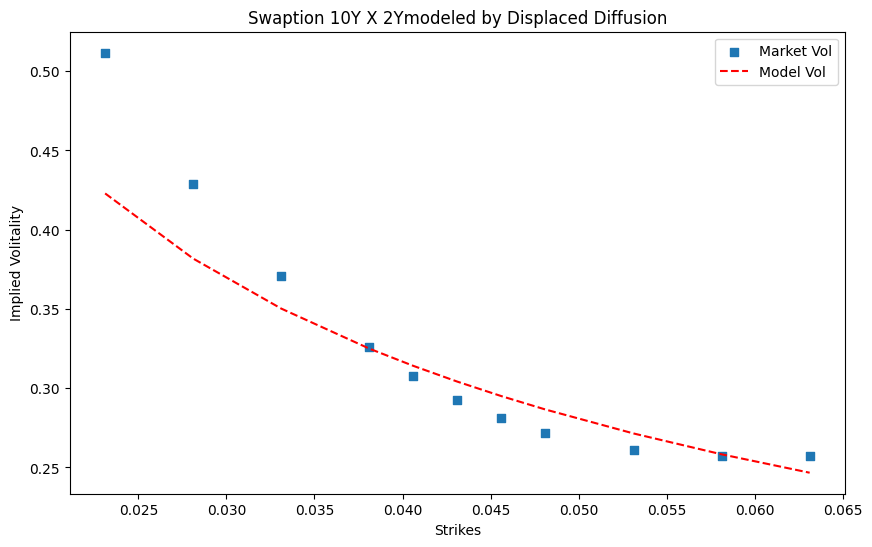

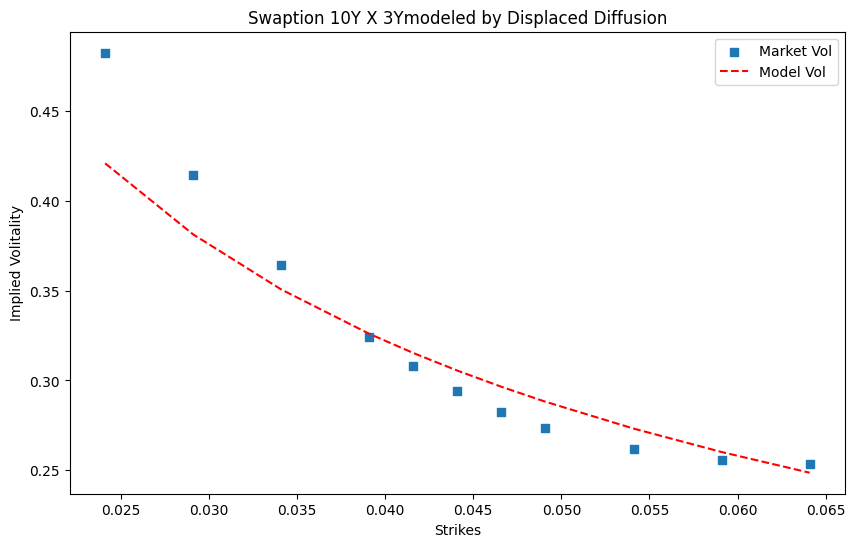

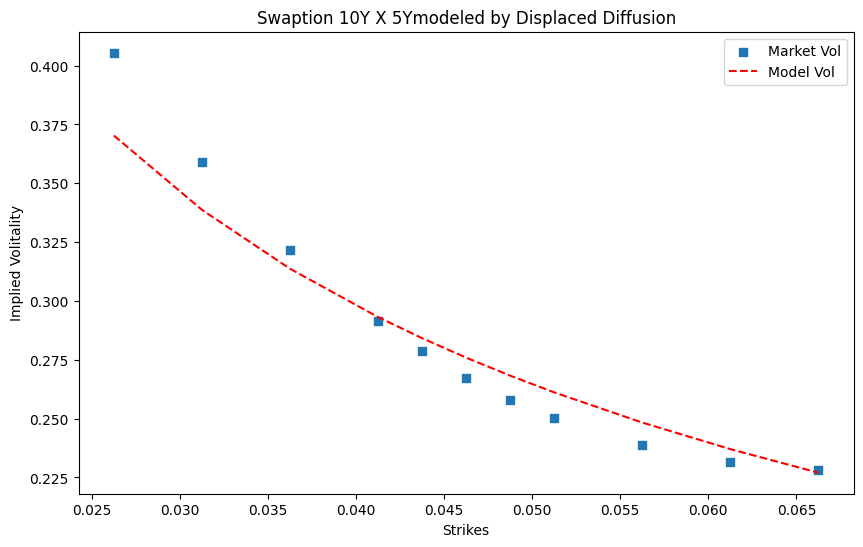

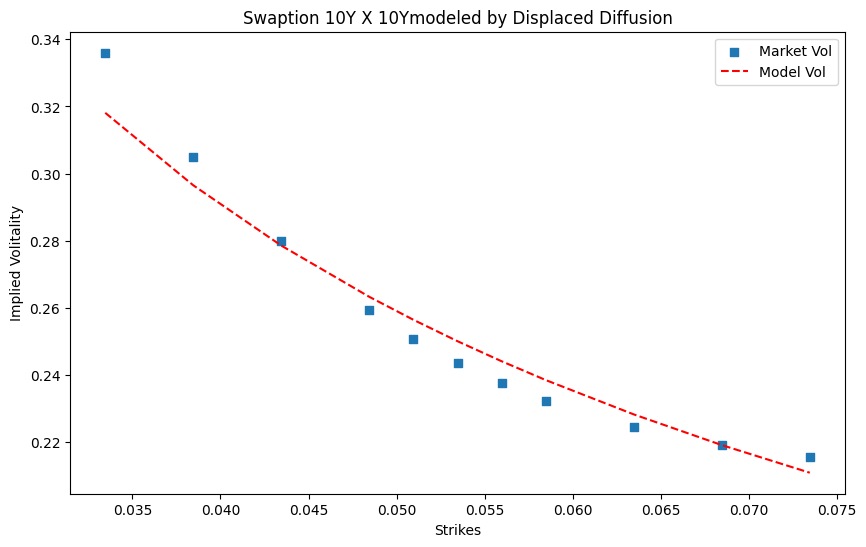

In [100]:
# plot the calibrated DD model with the market vols 
for ex in Expiry:
    for T in Tenor:
        fsr = fsw.loc[ex,T]
        strikes =\
            fsr + np.array(swaption.columns)
        market_vol =\
            swaption.loc[(str(ex)+'Y', 
                          str(T)+'Y'),:].values
        OIS_DF =\
            df_all\
            .loc[(df_all.index<=ex+T) &\
                 (df_all.index>ex)]\
            ['OIS DF']
        pvbp =\
            0.5 * OIS_DF.sum()
        
        DD_vols =\
            [volatility(fsr, K, pvbp, ex, 
                        Sigma.loc[(str(ex)+'Y',
                                   str(T)+'Y')],
                        float(Beta.loc[(str(ex)+'Y',
                                        str(T)+'Y')]))\
             for K in strikes]

        plt.figure(figsize = (10,6))
        plt.xlabel('Strikes')  # Label for the x-axis
        plt.ylabel('Implied Volitality')  # Label for the y-axis
        plt.scatter(strikes,
                    market_vol,marker = 's', 
                    label = 'Market Vol')
        plt.plot(strikes, 
                 DD_vols,
                 '--r', 
                 label = 'Model Vol')
        plt.legend()
        plt.title(f"Swaption {str(ex)}Y X {str(T)}Y\
modeled by Displaced Diffusion")
        plt.show()

## <a id = "p2"> Q2. </a> SABR Model Calibration assume $\beta=0.9$ calibrate $\sigma$, $ \rho$ and $\nu$ [back to table of contents](#top)

First, we shall implement the SABR model. The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}


This can be implemented in Python as follows:

In [101]:
beta_fix = 0.9

In [102]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [103]:
def sabrcalibration(x, beta, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

In [104]:
sabr_Alpha =\
    pd.DataFrame(index=Expiry, 
                 columns=Tenor)
sabr_Rho = sabr_Alpha.copy()
sabr_Nu = sabr_Alpha.copy()

initialGuess_sabr=[0.15, -0.6, 0.5]

for ex in Expiry:
    for T in Tenor:             #Set sigma,T,ATM,strikes
        
        fsr = fsw.loc[ex,T]
        strikes =\
            fsr + np.array(swaption.columns)        
        market_vol =\
            swaption.loc[(str(ex)+'Y', 
                          str(T)+'Y'),:].values
       
        res=least_squares(lambda x: sabrcalibration(x,
                                           beta_fix,         
                                           strikes,
                                           market_vol,
                                           fsr,
                                           ex),
                          initialGuess_sabr,
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
        
        
        sabr_Alpha.loc[ex,T]=res.x[0]
        sabr_Rho.loc[ex,T]=res.x[1]
        sabr_Nu.loc[ex,T]=res.x[2]        
        
sabr_Alpha.columns =\
    [str(T) +'Y' for T in Tenor]
sabr_Alpha.index =\
    [str(ex) +'Y' for ex in sabr_Alpha.index]    
sabr_Alpha.index.name = 'Swaption SABR Alpha'
sabr_Alpha.to_csv('###P2 SABR Alpha.csv')
sabr_Rho.columns =\
    [str(T) +'Y' for T in Tenor]
sabr_Rho.index =\
    [str(ex) +'Y' for ex in sabr_Rho.index]
sabr_Rho.index.name = 'Swaption SABR Rho'
sabr_Rho.to_csv('###P2 SABR Rho.csv')
sabr_Nu.columns =\
    [str(T) +'Y' for T in Tenor]
sabr_Nu.index =\
    [str(ex) +'Y' for ex in sabr_Nu.index]
sabr_Nu.index.name = 'Swaption SABR Nu'
sabr_Nu.to_csv('###P2 SABR Nu.csv')

##### <a id = "p21"> </a> 2.1  $\alpha$, $\rho$ and $\nu$, assuming $\beta$=0.9 [back to table of contents](#top)

In [105]:
sabr_Alpha

,1Y,2Y,3Y,5Y,10Y
Swaption SABR Alpha,,,,,
1Y,0.139066,0.184646,0.196849,0.17807,0.171053
5Y,0.166601,0.199524,0.210373,0.19104,0.17701
10Y,0.177846,0.195667,0.208321,0.202042,0.181077


In [106]:
sabr_Rho

,1Y,2Y,3Y,5Y,10Y
Swaption SABR Rho,,,,,
1Y,-0.633247,-0.525117,-0.482843,-0.41447,-0.264432
5Y,-0.585586,-0.54699,-0.54988,-0.511199,-0.437109
10Y,-0.546935,-0.545584,-0.553741,-0.563938,-0.511636


In [107]:
sabr_Nu

,1Y,2Y,3Y,5Y,10Y
Swaption SABR Nu,,,,,
1Y,2.049561,1.677431,1.438152,1.064775,0.778196
5Y,1.340313,1.061987,0.936768,0.671637,0.497094
10Y,1.008553,0.926678,0.871791,0.720039,0.578078


In [108]:
def sabrvol(F, K, pvbp, T, alpha, beta, rho, nu):
    
    sigma = SABR(F, K, T, alpha, beta, rho, nu)
    if F <= K:
        price = Black76Call(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Call(F, K, x, pvbp, T),
                        0.5)
    else:
        price = Black76Put(F, K, sigma, pvbp, T)
        vol = fsolve(lambda x: price -
                        Black76Put(F, K,x,pvbp, T),
                        0.5)
    return vol[0]

##### <a id = "p22"> </a> 2.2  SABR and Displaced Diffusion plot [back to table of contents](#top)

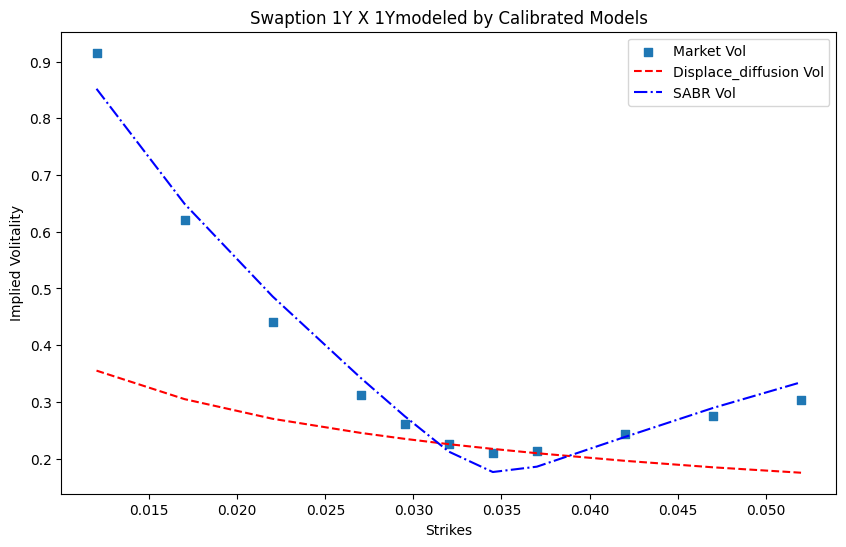

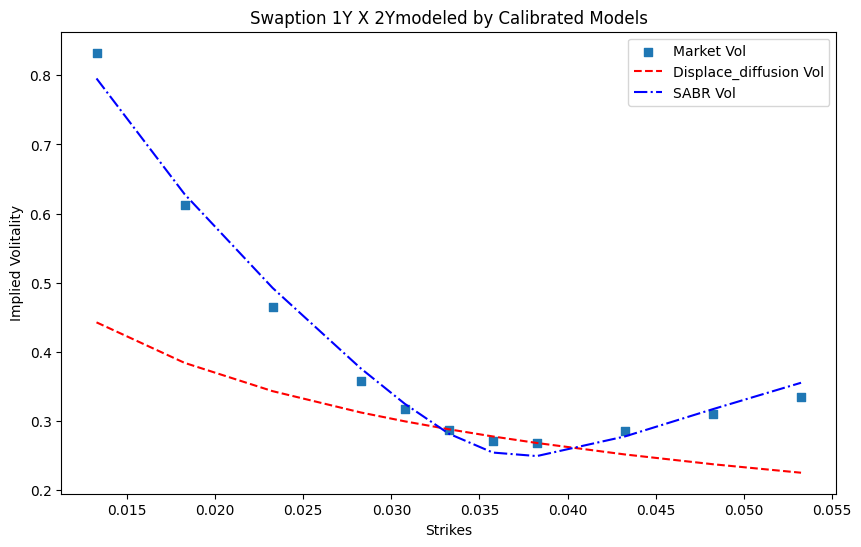

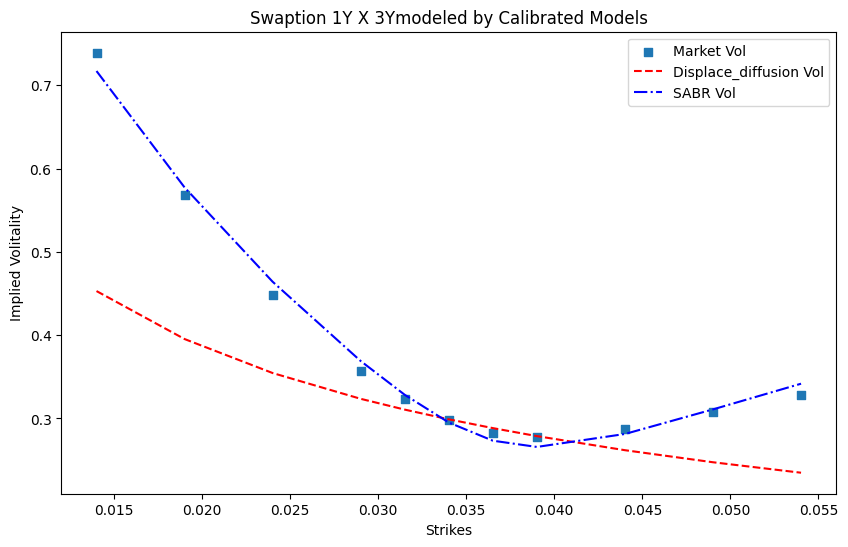

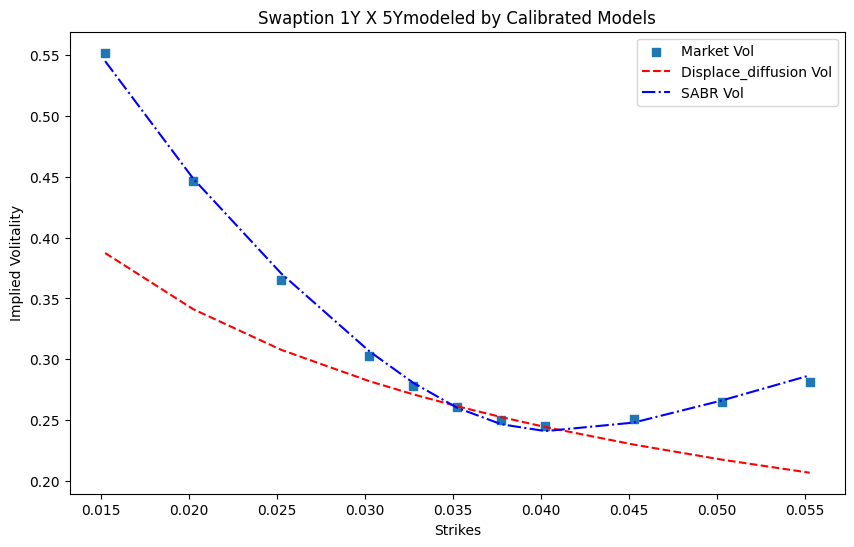

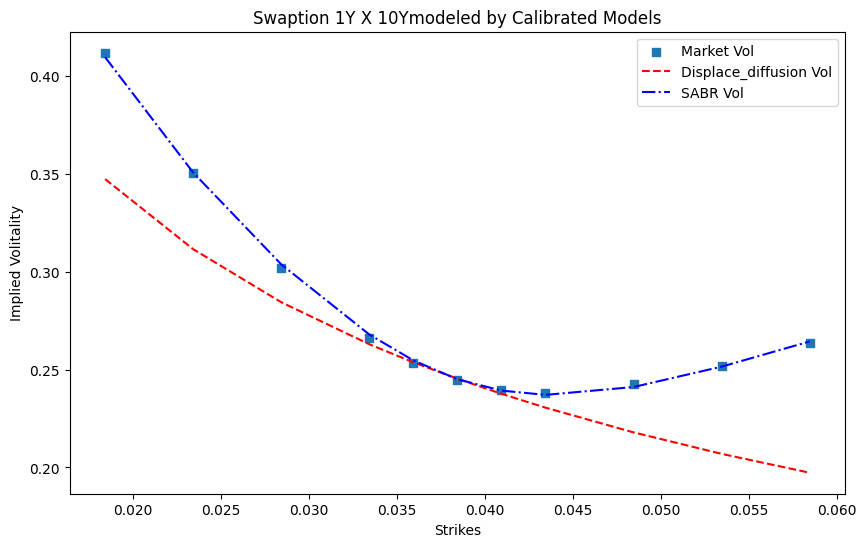

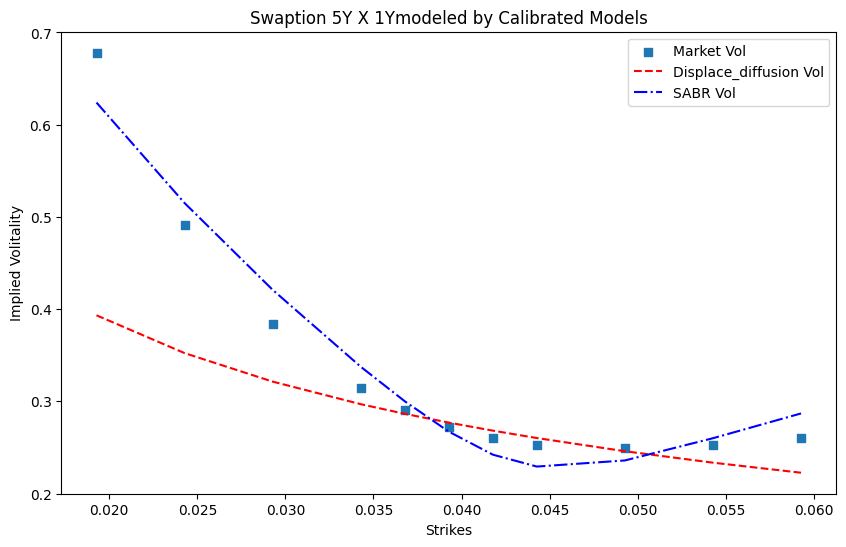

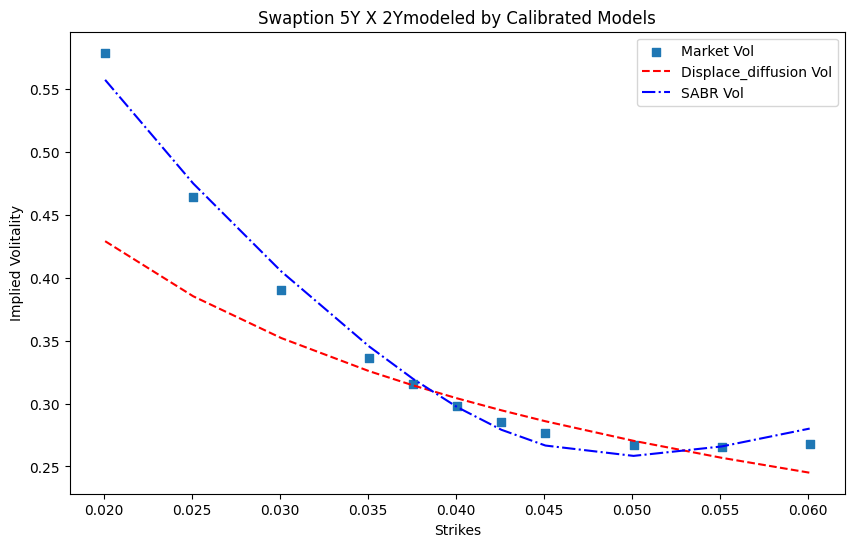

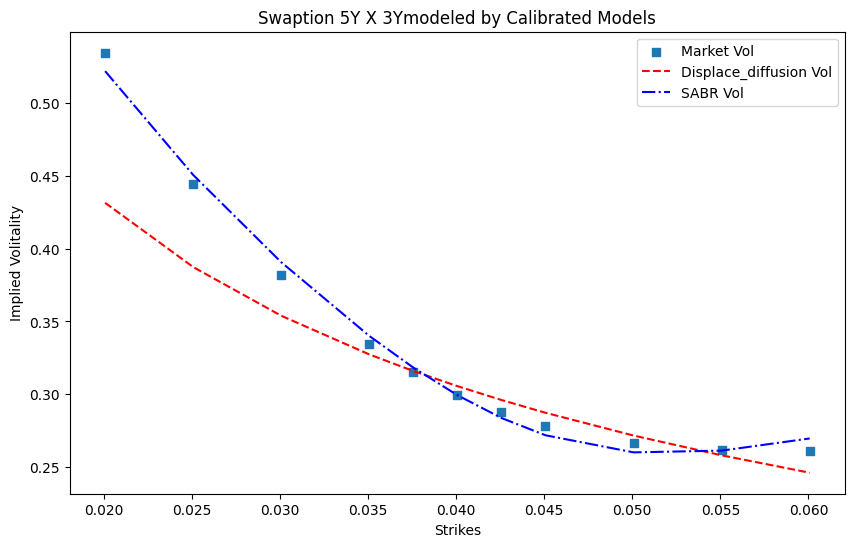

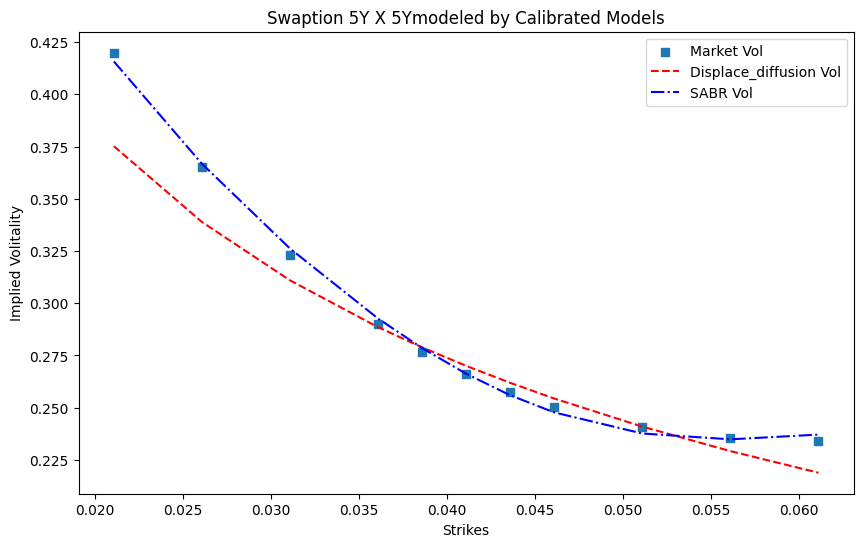

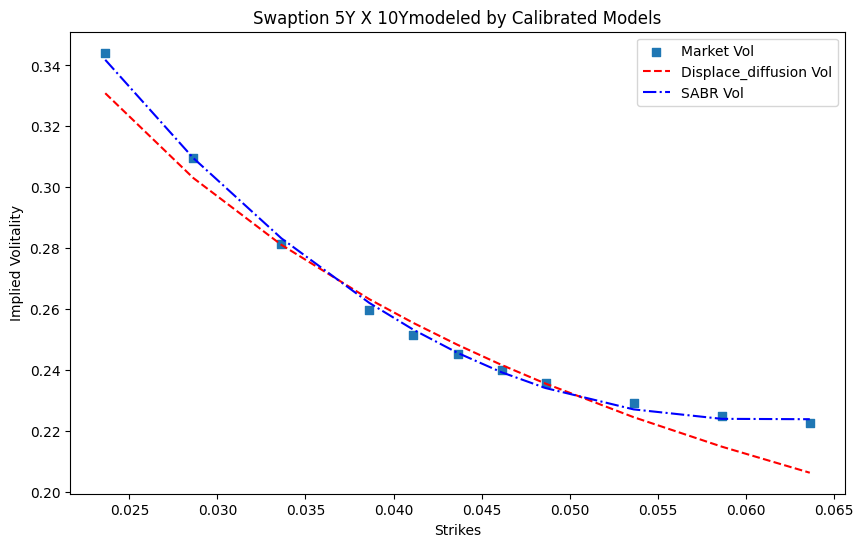

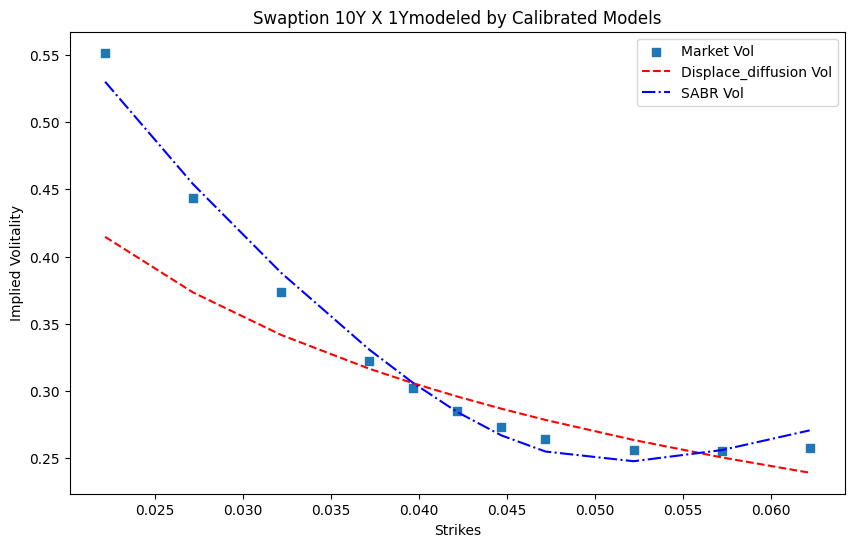

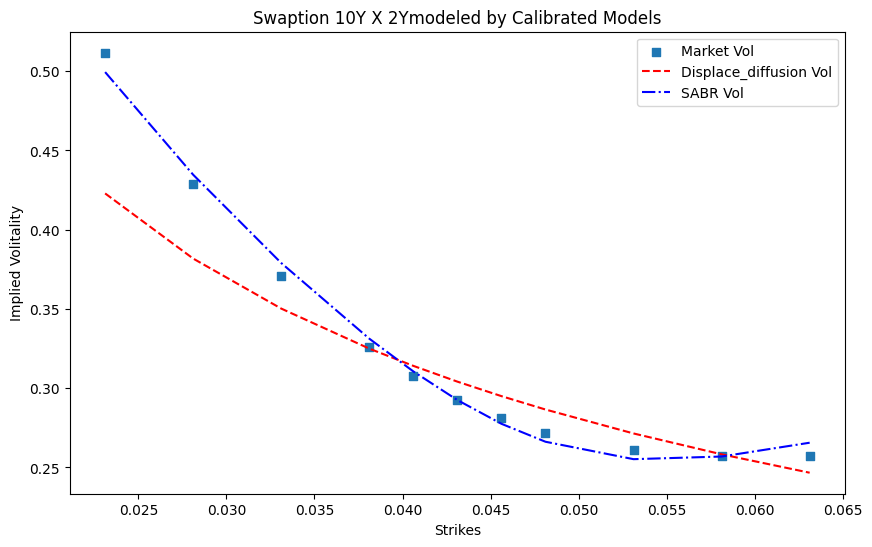

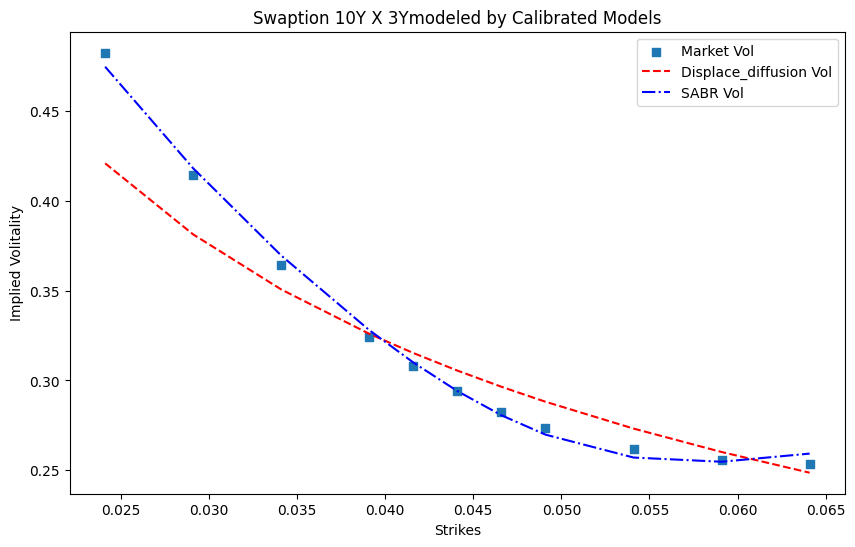

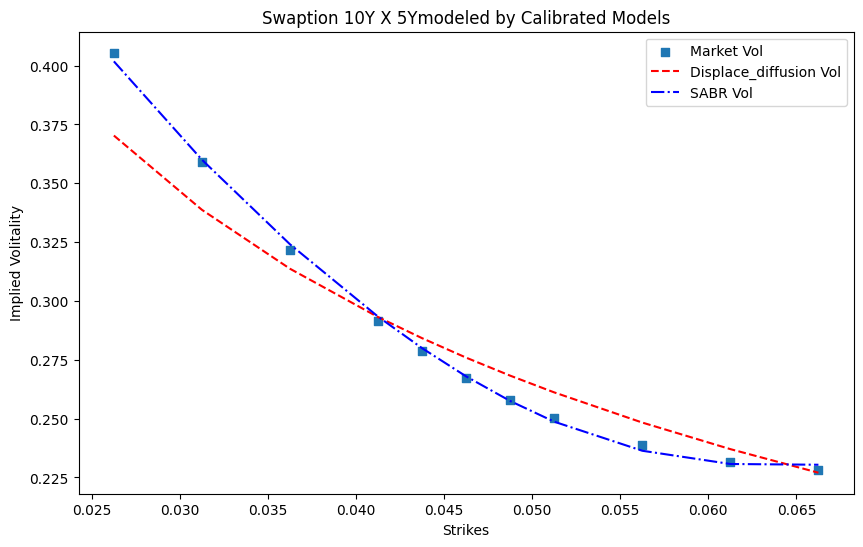

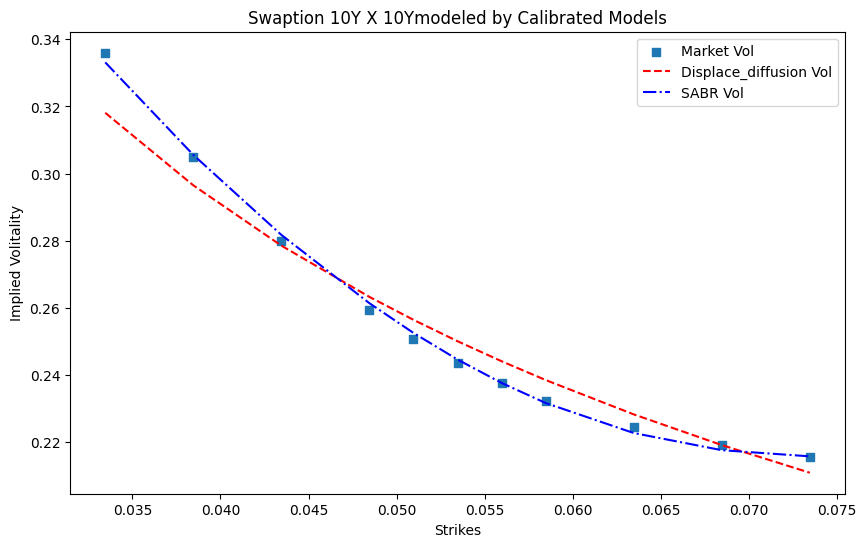

In [109]:
# plot the DD model and SABR model
for ex in Expiry:
    for T in Tenor:
        fsr = fsw.loc[ex,T]
        strikes =\
            fsr + np.array(swaption.columns)
        market_vol =\
            swaption.loc[(str(ex)+'Y', 
                          str(T)+'Y'),:].values
        OIS_DF =\
            df_all\
            .loc[(df_all.index<=ex+T) &\
                 (df_all.index>ex)]\
            ['OIS DF']
        pvbp =\
            0.5 * OIS_DF.sum()
        
        DD_vols =\
            [volatility(fsr, K, pvbp, ex, 
                        Sigma.loc[(str(ex)+'Y',
                                   str(T)+'Y')],
                        float(Beta.loc[(str(ex)+'Y',
                                        str(T)+'Y')]))\
             for K in strikes]
        SABR_vols =\
            [sabrvol(fsr, K, pvbp, ex, 
                     sabr_Alpha.loc[str(ex)+'Y',
                                    str(T)+'Y'], 
                     beta_fix,
                     sabr_Rho.loc[str(ex)+'Y',
                                  str(T)+'Y'], 
                     sabr_Nu.loc[str(ex)+'Y',
                                 str(T)+'Y'])\
             for K in strikes]
        
        plt.figure(figsize = (10,6))
        plt.scatter(strikes, market_vol,marker = 's', label= 'Market Vol')
        plt.plot(strikes, DD_vols, '--r', label = 'Displace_diffusion Vol')

        plt.plot(strikes, SABR_vols, '-.b', label = 'SABR Vol')
        plt.legend()
        plt.xlabel('Strikes')  # Label for the x-axis
        plt.ylabel('Implied Volitality')  # Label for the y-axis
        plt.title(f"Swaption {str(ex)}Y X {str(T)}Y\
modeled by Calibrated Models")
        plt.show()        

## <a id = "p3"> Q3. </a> Swaption Pricing with SABR and Calibrated DD Model [back to table of contents](#top)

In [110]:
expiry = [2, 8]
Tenor = [10]
S_q3=[]
for ex in expiry:
    S_Ts = []
    for T in Tenor:
        df_eff =\
            df_all.loc[ex:ex+T]
        
        fix_part_sum =\
            sum(df_eff.iloc[1:, 0])

        flt_part_sum = 0
        for i in range(1,len(df_eff)):
            flt_part_sum +=\
                df_eff.iloc[i,0] * \
                df_eff.iloc[i-1,1] /\
                df_eff.iloc[i,1]          
        
        S_T =\
            (flt_part_sum - fix_part_sum) /\
            (0.5 * fix_part_sum)
        S_Ts += [S_T]
        
        
    S_q3 += [S_Ts]
    
S_q3 = pd.DataFrame(S_q3, 
                 columns = ['X '+str(Tn)+'y' for Tn in Tenor], 
                 index = [str(Ex)+'y' for Ex in expiry])
S_q3.index.name = 'Expiry/Tenor'
S_q3.to_csv('###P2 Forward Swap Rate.csv')
S_q3


,X 10y
Expiry/Tenor,
2y,0.039634
8y,0.048711


In [111]:
def int_p2q3(df, col_key):
    int_df =\
        df[[col_key]]\
        .copy()\
        .astype(float)
        
    int_df.index = [1, 5, 10]
    int_df.columns = [10]    
    int_df =\
        pd.concat([int_df, 
                   pd.DataFrame(index = np.arange(1,10))], 
                  axis = 0)\
        .sort_index()\
        .reset_index()\
        .drop_duplicates(subset='index',
                         keep='first')\
        .set_index('index')\
        .interpolate()    
    return int_df

##### <a id = "p31"> </a> 3.1  Interplation on Displaced Diffusion $\sigma$ and $\beta$ [back to table of contents](#top)

In [112]:
q3_sigma =\
    int_p2q3(Sigma, '10Y')
q3_sigma.index.name = 'DD Sigma'
q3_sigma

,10
DD Sigma,
1,0.24470
2,0.24480
3,0.24490
4,0.24500
5,0.24510
6,0.24482
7,0.24454
8,0.24426
9,0.24398


In [113]:
q3_beta =\
    int_p2q3(Beta, '10Y')
q3_beta.index.name = 'DD Beta'
q3_beta

,10
DD Beta,
1,0.000025
2,0.014466
3,0.028907
4,0.043349
5,0.057790
6,0.046361
7,0.034932
8,0.023504
9,0.012075


##### <a id = "p32"> </a> 3.2  Interplation on SABR $\alpha$, $\rho$, and $\nu$, assuming $\beta$=0.9 [back to table of contents](#top)

In [114]:
q3_alpha =\
    int_p2q3(sabr_Alpha, '10Y')
q3_alpha.index.name = 'SABR Alpha'
q3_alpha

,10
SABR Alpha,
1,0.171053
2,0.172542
3,0.174031
4,0.175521
5,0.177010
6,0.177823
7,0.178637
8,0.179450
9,0.180264


In [115]:
q3_nu =\
    int_p2q3(sabr_Nu, '10Y')
q3_nu.index.name = 'SABR Nu'
q3_nu

,10
SABR Nu,
1,0.778196
2,0.707921
3,0.637645
4,0.567370
5,0.497094
6,0.513291
7,0.529488
8,0.545684
9,0.561881


In [116]:
q3_rho =\
    int_p2q3(sabr_Rho, '10Y')
q3_rho.index.name = 'SABR Rho'
q3_rho

,10
SABR Rho,
1,-0.264432
2,-0.307602
3,-0.350771
4,-0.393940
5,-0.437109
6,-0.452015
7,-0.466920
8,-0.481825
9,-0.496731


In [117]:
df_all

,OIS DF,LIBOR DF
Tenor,,
0.5,0.998752,0.987654
1.0,0.997009,0.972577
1.5,0.995270,0.957378
2.0,0.993531,0.942179
2.5,0.991773,0.926330
3.0,0.990015,0.910482
3.5,0.988066,0.894731
4.0,0.986117,0.878981
4.5,0.984150,0.863985


##### <a id = "p33"> </a> 3.3  Payer Swaption 2$y$ X 10$y$ [back to table of contents](#top)

In [118]:
S_q3

,X 10y
Expiry/Tenor,
2y,0.039634
8y,0.048711


In [119]:
strikes_q3 = np.arange(0.01, 0.09, 0.01)
strikes_q3

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])

In [120]:
fsw1 = S_q3.iloc[0, 0]
T1 = 2
fsw1, T1

(0.0396343767731699, 2)

In [121]:
sigma1=q3_sigma.loc[2, 10]
beta1=q3_beta.loc[2, 10]
sigma1, beta1

(0.24480000000000002, 0.01446616975)

In [122]:
alpha1=q3_alpha.loc[2, 10]
rho1=q3_rho.loc[2, 10]
nu1=q3_nu.loc[2, 10]

alpha1, rho1, nu1, beta_fix

(0.17254201953416323, -0.30760150316316937, 0.707920971908719, 0.9)

In [123]:
pvbp1 =\
    0.5 *\
    sum(df_all['OIS DF'].loc[2.5:12])
pvbp1

9.699535688510332

In [124]:
payer_DD =\
    [DD_Call(fsw1, 
             K,
             sigma1, 
             pvbp1,
             beta1,
             T1) for K in strikes_q3]  
payer_SABR =\
    [Black76Call(fsw1,
                 K,
                 SABR(fsw1,K,T1,alpha1,beta_fix,rho1,nu1),
                 pvbp1, 
                 T1) for K in strikes_q3]
payer2by10 =\
    pd.DataFrame({'DD price': payer_DD,
                  'SABR price': payer_SABR},
                 index = strikes_q3)
payer2by10.index.name = 'Strikes'
payer2by10.to_csv('###P2 Payer Swaption 2yX10y.csv')
payer2by10

,DD price,SABR price
Strikes,,
0.01,0.288141,0.289610
0.02,0.194933,0.198313
0.03,0.112323,0.115187
0.04,0.051345,0.052151
0.05,0.017369,0.021376
0.06,0.004109,0.010746
0.07,0.000652,0.006628
0.08,0.000068,0.004647


##### <a id = "p34"> </a> 3.4  Receiver Swaption 8$y$ X 10$y$ [back to table of contents](#top)

In [125]:
fsw2 = S_q3.iloc[1, 0]
T2 = 8
fsw2, T2

(0.048711148942116915, 8)

In [126]:
sigma2=q3_sigma.loc[8, 10]
beta2=q3_beta.loc[8, 10]
sigma2, beta2

(0.24426, 0.023503539999999996)

In [127]:
alpha2=q3_alpha.loc[8, 10]
rho2=q3_rho.loc[8, 10]
nu2=q3_nu.loc[8, 10]

alpha2, rho2, nu2, beta_fix

(0.17945035037108364, -0.4818254967722523, 0.5456843988652061, 0.9)

In [128]:
pvbp2 =\
    0.5 *\
    sum(df_all['OIS DF'].loc[8.5:18])
pvbp2

9.375969869808888

In [129]:
receiver_DD =\
    [DD_Put(fsw2,
            K,
            sigma2,
            pvbp2,
            beta2,
            T2) for K in strikes_q3]  
receiver_SABR =\
    [Black76Put(fsw2,
                K,
                SABR(fsw2,K,T2,alpha2,beta_fix,rho2,nu2),
                pvbp2,
                T2) for K in strikes_q3]
receiver8by10 =\
    pd.DataFrame({'DD price': receiver_DD,
                  'SABR price': receiver_SABR},
                 index = strikes_q3)
receiver8by10.index.name = 'Strikes'
receiver8by10.to_csv('###P2 Receiver Swaption 8yX10y.csv')
receiver8by10

,DD price,SABR price
Strikes,,
0.01,0.018978,0.019280
0.02,0.033897,0.038490
0.03,0.056643,0.061206
0.04,0.088977,0.090336
0.05,0.132051,0.130391
0.06,0.186140,0.186164
0.07,0.250588,0.257379
0.08,0.323978,0.338579
